### **Deploy: Detecção de fraude em cartão de crédito**


---


Tradução e adaptação do código: Rodrigo da Costa Aglinskas

Projeto: Detecção de fraude em cartão de crédito

Desafio de projeto: Análise em Python com uso da biblioteca Pandas - DIO

Iniciado em 11/09/2021
Concluído em 14/09/2021


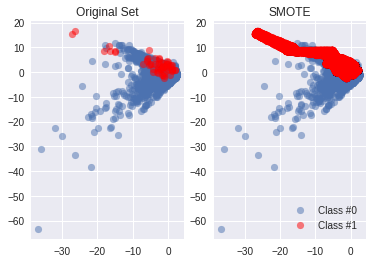

### **Importando arquivos e bibliotecas**

In [1]:
# Importando as bibliotecas:

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import six
import sys
sys.modules['sklearn.externals.six'] = six

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Configuração Pandas:

pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [3]:
# Leitura de arquivos:

#cc1_file = 'creditcard_sampledata.csv'

# arquivo original df com 147 MB
df = pd.read_csv('creditcard_fraud2.csv', error_bad_lines=False)
# Executando a amostra df3
df3 = pd.read_csv('amostraFraude.csv', error_bad_lines=False)

# dados não rotulados
#banksim_file = 'banksim.csv'
banksim_file = 'bankSim2.csv'
banksim_adj_file = 'banksim_adj.csv'
# arquivos pickle:
db_full_file = 'XGB-BankSim.pkl'
labels_file = 'labels.pickle'
labels_full_file = 'labels_full.pickle'
x_scaled_file = 'x_scaled.pickle'
x_scaled_full_file = 'x_scaled_full.pickle'

# Detecção de fraude em textos
enron_emails_clean_file = 'enron_emails_clean.csv'
cleantext_file = 'cleantext.pickle'
corpus_file = 'corpus.pickle'
dict_file = 'dict.pickle'
ldamodel_file = 'ldamodel.pickle'


### **Tratando os dados**

In [96]:
# Criando uma amostra de 10% do df original
# df2 = df.sample(frac=0.10)

In [97]:
# Baixando a amostra
# df2.to_csv('amostraFraude.csv', encoding='utf-8', index=False)

In [98]:
# Verificando a estrutura do dataframe
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28679 entries, 0 to 28678
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  28679 non-null  int64  
 1   V1          28679 non-null  float64
 2   V2          28679 non-null  float64
 3   V3          28679 non-null  float64
 4   V4          28679 non-null  float64
 5   V5          28679 non-null  float64
 6   V6          28679 non-null  float64
 7   V7          28679 non-null  float64
 8   V8          28679 non-null  float64
 9   V9          28679 non-null  float64
 10  V10         28679 non-null  float64
 11  V11         28679 non-null  float64
 12  V12         28679 non-null  float64
 13  V13         28679 non-null  float64
 14  V14         28679 non-null  float64
 15  V15         28679 non-null  float64
 16  V16         28679 non-null  float64
 17  V17         28679 non-null  float64
 18  V18         28679 non-null  float64
 19  V19         28679 non-nul

In [99]:
df3.dtypes

Unnamed: 0      int64
V1            float64
V2            float64
V3            float64
V4            float64
V5            float64
V6            float64
V7            float64
V8            float64
V9            float64
V10           float64
V11           float64
V12           float64
V13           float64
V14           float64
V15           float64
V16           float64
V17           float64
V18           float64
V19           float64
V20           float64
V21           float64
V22           float64
V23           float64
V24           float64
V25           float64
V26           float64
V27           float64
V28           float64
Amount        float64
Class          object
dtype: object

In [100]:
#df["V4"] = pd.to_numeric(df["V4"], downcast="float")
# Convertendo coluna Class de object para int

# df3['Class'] = pd.to_numeric(df3['Class'])

# ERRO: ValueError: Unable to parse string "1'" at position 201

In [101]:
# Localizando os valores com problema:

df3.loc[df3['Class']=="1'"]

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
201,28143,-27.143678,15.365804,-28.407424,6.370895,-20.087878,-4.666313,-18.709479,17.903574,-3.722279,-8.120962,4.419943,-6.210941,1.063837,-5.843528,-0.108836,-5.606597,-11.756256,-4.714947,0.783578,1.703888,1.796826,-1.960974,-0.902247,0.144011,2.024388,-0.204214,1.332153,0.385891,99.99,1'
323,152058,-3.576362,3.299436,-7.460433,7.783634,-0.398549,-1.968441,-3.110476,-0.328404,-1.574363,-2.497561,4.604170,-9.001915,-1.276324,-13.969471,1.256945,-4.491629,-5.969987,-1.274666,1.147784,-0.181455,0.540731,0.719526,0.379249,-0.616962,-0.442811,0.359841,-2.651825,0.422184,1.00,1'
861,110087,1.934946,0.650678,-0.286957,3.987828,0.316052,-0.099449,-0.021483,-0.172327,0.508730,1.072955,-0.427567,-2.777649,1.637140,1.571080,-1.445367,0.908650,-0.122016,-0.104110,-1.684022,-0.344452,-0.173602,-0.190974,0.219976,-0.216597,-0.136692,-0.129954,-0.050077,-0.051082,1.00,1'
1250,102676,-5.552122,5.678134,-9.775528,8.416295,-4.409844,-1.506235,-6.899839,3.750443,-3.879793,-6.864164,7.051065,-10.137529,2.815440,-9.909168,-0.262230,-5.022557,-8.522975,-2.012939,1.525732,-0.064780,1.128472,0.228484,0.286258,-0.536294,-0.104925,0.420919,-0.297557,-0.946184,119.74,1'
1627,143434,-2.729482,3.312495,-4.242710,5.036985,-0.376561,-1.532462,-3.449159,1.856839,-3.623334,-5.653638,3.942316,-5.883724,-1.347814,-9.266120,-2.459556,-2.205644,-5.709087,-1.113937,-1.556530,0.164288,0.727415,-0.301432,-0.502433,-0.462309,0.510683,0.046665,0.514646,0.140999,1.00,1'
1963,102480,-1.929597,4.066413,-4.865184,5.898602,-0.552493,-1.555962,-3.833623,0.679512,-3.463765,-6.683689,7.021278,-11.102493,1.711755,-10.447633,-2.799076,-6.261741,-11.647158,-3.451436,-0.507537,0.942489,1.137212,0.674245,-0.531765,-0.433409,0.378659,0.198107,0.869694,0.228048,0.00,1'
2271,148479,-1.541678,3.846800,-7.604114,3.121459,-1.254924,-2.084875,-2.385027,1.471140,-2.530507,-5.175660,1.927186,-6.011155,-1.195601,-6.745561,-0.058091,-4.325132,-5.558067,-1.580531,0.971906,0.114760,1.096405,1.064222,0.065370,0.257209,-0.693654,-0.335702,0.577052,0.398348,122.68,1'
2353,133184,-1.212682,-2.484824,-6.397186,3.670562,-0.863375,-1.855855,1.017732,-0.544704,-1.703378,-3.739659,1.738124,-2.844449,0.765864,-4.799737,-0.011335,-2.693168,-3.166955,-1.067800,-0.559132,2.908374,1.396872,0.092073,-1.492882,-0.204227,0.532511,-0.293871,0.212663,0.431095,1335.00,1'
2562,153653,-5.192496,3.164721,-5.047679,2.246597,-4.011781,-0.638908,-2.873463,1.576318,-2.861986,-2.120458,1.863596,-3.620252,-1.480714,-1.583343,-1.230469,-1.202298,-6.167637,-2.651539,0.013588,-1.850470,1.167244,-1.006617,0.774562,0.063397,-0.390658,1.884741,-1.742558,-0.082216,247.86,1'
2659,41397,-14.970346,8.401421,-16.867238,8.252334,-13.565130,-2.782438,-14.263735,9.643419,-7.701499,-14.226698,5.610999,-11.793979,1.598387,-11.606970,-0.044180,-9.286955,-19.899726,-7.518051,1.243517,-1.614660,2.714045,-0.101355,-0.439666,0.519514,0.789328,0.064357,-1.621386,-1.104819,273.01,1'


In [102]:
# erro: valores estão como 1', substituindo por 1:

df3['Class']= df3['Class'].replace(["1'"],["1"])

In [103]:
# Tentando novamente converter coluna Class de object para int

df3['Class'] = pd.to_numeric(df3['Class'])

# Agora funcionou.

In [104]:
# Checando os tipos:

df3.dtypes

Unnamed: 0      int64
V1            float64
V2            float64
V3            float64
V4            float64
V5            float64
V6            float64
V7            float64
V8            float64
V9            float64
V10           float64
V11           float64
V12           float64
V13           float64
V14           float64
V15           float64
V16           float64
V17           float64
V18           float64
V19           float64
V20           float64
V21           float64
V22           float64
V23           float64
V24           float64
V25           float64
V26           float64
V27           float64
V28           float64
Amount        float64
Class           int64
dtype: object

In [105]:
df3.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,165825,2.009861,-0.869738,-1.754567,-0.423925,-0.186998,-0.756014,0.067375,-0.372006,-0.675936,0.841376,-1.173789,0.041871,0.501777,0.204775,-0.207727,-1.730563,-0.038104,0.588551,-0.531336,-0.358859,-0.451073,-0.949828,0.189053,0.581766,-0.152222,0.484464,-0.095600,-0.042231,113.96,0
1,146492,-1.804326,1.504552,-0.233085,-1.229363,1.502214,-0.347973,2.406507,-1.635108,2.463650,4.251623,1.835383,0.484691,0.557624,-1.710859,0.174277,-1.041797,-1.570204,0.131513,0.051017,1.408423,-0.299683,1.489198,-0.243334,0.744379,-0.480553,-0.435355,0.128771,-0.350759,44.99,0
2,96364,-0.826149,0.687367,0.833079,-0.538347,0.039801,0.080615,-0.206940,0.513953,1.749362,-1.191956,-1.421861,-2.980938,1.457096,1.406513,-0.710242,0.673623,-0.008299,0.930974,-0.226166,-0.023124,0.102609,0.576929,-0.246134,-1.012641,-0.208986,0.625561,0.218520,0.119810,29.99,0
3,120477,2.098926,0.318974,-2.724961,0.394636,1.246655,-0.707107,0.649341,-0.299002,-0.180722,-0.151160,0.755647,0.610829,0.035880,-0.528841,-0.871319,0.101675,0.360497,0.479553,0.384748,-0.138251,0.054431,0.311851,-0.107287,0.167923,0.483469,0.510968,-0.093167,-0.062508,5.95,0
4,86469,2.183102,-1.566933,-0.515539,-1.662056,-1.455993,-0.221062,-1.400477,-0.007258,-1.245094,1.663325,0.382201,0.017236,0.821759,-0.482807,-0.631955,0.076368,-0.059152,0.446303,0.312842,-0.314990,-0.358131,-0.652055,0.359658,-0.553220,-0.580116,-0.478611,0.028788,-0.042655,50.70,0


In [106]:
df3.tail()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
28674,128662,-0.294122,1.123794,0.040958,-0.665765,1.281603,-0.162226,1.105000,-0.192295,-0.169560,-0.471611,-1.338463,0.717218,1.702484,-0.151829,-0.063187,-0.424049,-0.611863,-0.366802,0.819757,0.162406,-0.214339,-0.388622,-0.067642,0.044649,-0.317071,-0.578125,0.296198,0.258734,1.51,0
28675,34756,0.861545,-1.065624,0.672919,0.570590,-1.205622,0.270839,-0.673109,0.221099,-0.896328,0.910822,1.060932,0.067018,-0.761531,0.446580,0.763152,-1.066885,-0.262822,1.758951,-1.506077,-0.241190,-0.065595,-0.155664,-0.118910,-0.034928,0.180498,-0.303340,0.039835,0.054071,194.00,0
28676,163538,2.215685,-1.486828,-0.436634,-1.676735,-1.439594,-0.110422,-1.507187,0.080852,-1.244714,1.677778,0.770808,-0.013614,0.454077,-0.415370,-0.596509,-0.035197,0.118078,0.345783,0.143921,-0.381301,-0.352085,-0.623079,0.488874,0.692703,-0.628297,-0.540289,0.028271,-0.036328,20.44,0
28677,25392,-0.829840,0.902751,1.101257,-0.707799,0.467336,-0.432122,0.870202,0.053977,-0.526561,-0.338157,1.086305,-0.117237,-1.712846,0.723435,-0.230119,0.156395,-0.500400,-0.187507,-0.845804,-0.319004,0.136557,0.188836,-0.150558,-0.002626,-0.155511,0.151353,-0.228816,0.097313,7.39,0
28678,62148,0.558709,-1.662584,0.547547,-1.199303,-1.550289,-0.166150,-0.435430,0.141454,1.741713,-1.235611,1.665720,1.461313,-0.324424,0.143366,0.982897,-0.582065,0.059827,0.302927,0.474186,0.516672,0.399864,0.691597,-0.346612,0.304658,0.254879,-0.019036,0.004588,0.067589,321.42,0


In [107]:
# o df tem valores com NaN
# Substituindo por zero:

df3 = df3.replace(np.nan, 0)

### **Verificando a relação fraude x não fraude**

In [108]:
# Conta ocorrências de fraude and não fraude e imprime:

occ = df3['Class'].value_counts()
occ

0    28622
1       57
Name: Class, dtype: int64

In [109]:
# Imprime a Razão de casos de fraude em relação ao total:

ratio_cases = occ/len(df3.index)
print(f'Razão de ocorrências de fraude: {ratio_cases[1]}\nRazão de ocorrências não fraudulentas: {ratio_cases[0]}')

Razão de ocorrências de fraude: 0.001987516998500645
Razão de ocorrências não fraudulentas: 0.9980124830014994


### **Visualização de dados**

In [110]:
# função preparando o df

def prep_data(df3: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df3.iloc[:, 1:28].values
    y = df3.Class.values
    return X, y

In [111]:
# Função cria um scatter plot dos dados e etiquetas
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [112]:
# Cria X e y da função prep_data
X, y = prep_data(df3)

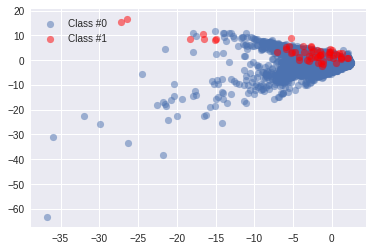

In [113]:
# Gerando gráfico dos dados pela função plot data em X and y
plot_data(X, y)

### **Reamostragem de dados: aumenta a detecção bem-sucedida**

In [114]:
# Undersampling  x Oversampling

# Implementando métodos de reamostragem usando o módulo Python imblean 

from imblearn.over_sampling import RandomOverSampler



# Define o método de reamostragem em treino e teste
method = SMOTE(kind='borderline1')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Aplica a reamostragem apenas aos dados de treinamento 
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

# Ajusta o modelo e obtém previsões
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Obtem métricas de desempenho do modelo
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5726
           1       0.09      0.70      0.16        10

    accuracy                           0.99      5736
   macro avg       0.54      0.84      0.57      5736
weighted avg       1.00      0.99      0.99      5736



In [115]:
# Métodos de reamostragem para dados desequilibrados
# Aplicando o Synthetic Minority Oversampling Technique (SMOTE)

# Executando a função prep_data
X, y = prep_data(df3)

In [116]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (28679, 27)
y shape: (28679,)


In [117]:
# Definindo o método de reamostragem
method = SMOTE()

In [118]:
# Cria um conjunto de recursos reamostrado 
X_resampled, y_resampled = method.fit_sample(X, y)

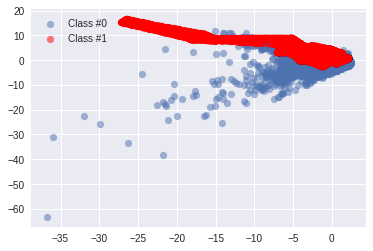

In [119]:
# Plotando os dados reamostrados 
plot_data(X_resampled, y_resampled)

In [120]:
df3 = df3.loc[:, df3.notnull().any(axis = 0)]

In [121]:
#Compare SMOTE to original data

pd.value_counts(pd.Series(y))

0    28622
1       57
dtype: int64

In [122]:
pd.value_counts(pd.Series(y_resampled))



1    28622
0    28622
dtype: int64

In [123]:
# Função compara o df original com o de reamostragem:

def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

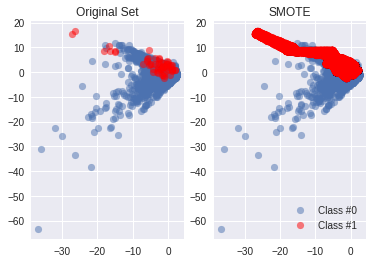

In [124]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

### **Algoritmos de detecção de fraude**

In [125]:
# Sistemas baseados em Machine Learning

# 1: divide os recursos e rótulos em dados de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = LinearRegression().fit(X_train, y_train)

In [127]:
# 2: Define o modelo a usar
model = LinearRegression()

In [128]:
# 3: Ajusta o modelo aos dados de treino
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [129]:
# 4: Obtém o modelo preditivo para os dados de teste
y_predicted = model.predict(X_test)

In [130]:
# 5: Compara y_test as previsões e obtém métricas de performance (r^2 score)
r2_score(y_test, y_predicted)

0.37698838242669364

In [131]:
# Método tradicional de detecção de fraude:

df3.drop(['Unnamed: 0'], axis=1, inplace=True)

In [132]:
df3.groupby('Class').mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.003815,0.005845,0.020565,0.004905,-0.002227,-0.002078,0.010797,0.006168,0.006361,0.012918,-0.006868,0.005639,0.002415,0.010903,0.001279,0.016298,0.011602,0.004340,-0.007331,0.003145,-0.004587,0.004447,0.001998,0.002444,-0.001304,-0.003552,-0.000548,0.000944,87.826572
1,-4.013088,3.308645,-6.190117,4.352649,-2.395297,-1.454933,-4.468554,0.984189,-2.387344,-4.866564,3.334521,-5.664783,-0.178809,-6.511112,-0.274369,-3.345101,-5.393370,-1.739826,0.261792,0.202952,0.898711,-0.190464,-0.453193,-0.115884,0.066830,0.130515,-0.023141,0.087371,139.452281


In [133]:
df3['flag_as_fraud'] = np.where(np.logical_and(df3.V1 < -3, df3.V3 < -5), 1, 0)

In [134]:
pd.crosstab(df3.Class, df3.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud'])

Flagged Fraud,0,1
Actual Fraud,,
0,28487,135
1,41,16


**Using ML classification to catch fraud**

In [135]:
# Criando conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [136]:
# Ajustando o modelo de regressão logístrica aos dados
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [137]:
# Obtendo modelos preditivos
predicted = model.predict(X_test)

In [138]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8584
           1       0.86      0.60      0.71        20

    accuracy                           1.00      8604
   macro avg       0.93      0.80      0.85      8604
weighted avg       1.00      1.00      1.00      8604

Confusion matrix:
 [[8582    2]
 [   8   12]]


**Regressão Logístrica com SMOTE**

In [139]:
# Definindo qual método de reamostragem e o modelo de ML do pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

In [140]:
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

**Pipelining**

In [141]:
# Separando os dados em X e y, em conjunto de treino e teste e ajustando o pipeline nos dados de treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [142]:
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

In [143]:
# Obtendo os resultados do relatório de classificação e matriz de confusão 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      8584
           1       0.18      0.75      0.29        20

    accuracy                           0.99      8604
   macro avg       0.59      0.87      0.64      8604
weighted avg       1.00      0.99      0.99      8604

Confusion matrix:
 [[8517   67]
 [   5   15]]


### **Detecção de fraude usando dados rotulados**

In [144]:
# Criando uma amostra de 15% do df original
df4 = df.sample(frac=0.15)

# tratando erro: valores estão como 0' e 1', substituindo por 0 e 1:
df4['Class']= df4['Class'].replace(["1'"],["1"])
df4['Class']= df4['Class'].replace(["0'"],["0"])

df4['Class'] = pd.to_numeric(df4['Class'])

df4.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
242015,151292.0,-0.339345,0.547517,0.455477,-0.236321,0.108504,-0.721153,0.768683,-0.156875,0.474171,-0.360057,-0.999018,0.169460,0.082263,0.003228,0.227323,-0.399837,-0.350975,-0.032722,0.133944,0.007903,0.167842,0.739621,0.076945,-0.002166,-0.964808,-0.431068,0.401819,0.338146,63.44,0
168784,119383.0,1.641231,-1.067560,-0.990142,-0.124562,0.256115,1.832865,-0.841099,0.586227,0.886464,0.040079,0.829682,0.697178,-0.190917,0.251796,1.093939,0.121024,-0.313735,-0.453598,-0.924068,0.031625,0.335131,0.821249,0.101849,-0.896933,-0.547330,0.720304,-0.023325,-0.046847,140.73,0
114369,73453.0,-0.604094,1.256435,1.073828,-0.157100,0.160641,-0.310622,0.310672,-0.670600,-0.519614,-0.262739,1.130258,0.403929,-0.226707,-0.167287,0.233108,0.696106,-0.283175,0.515108,0.310520,-0.052005,0.524618,-0.922808,0.044982,-0.075891,-0.137742,0.082470,0.276006,0.091194,3.27,0
283489,171632.0,-1.394751,1.572371,0.295634,-0.191430,-0.024531,-0.084173,0.175457,0.836211,-1.067765,-0.675293,0.460150,0.548253,-0.618765,1.081584,-0.483960,-0.277637,0.330567,0.058425,1.639282,-0.192502,-0.084388,-0.608496,-0.180506,0.776807,0.441702,0.505842,-0.542622,-0.088924,10.34,0
89745,62706.0,1.018412,1.036663,-1.689814,1.315476,1.698436,0.528807,0.331715,0.364539,-0.711798,-1.570288,3.463018,0.538411,-0.378095,-3.045495,1.468911,-0.029742,3.664588,-0.105190,-2.097944,-0.167555,-0.040238,0.096172,-0.092549,-1.345664,0.510305,-0.182674,0.107058,0.071818,0.89,0


In [145]:
# Baixando a amostra
df4.to_csv('amostraFraude2.csv', encoding='utf-8', index=False)

In [146]:
# Visualizando o corpo do df4
X, y = prep_data(df4)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (42721, 27)
y shape: (42721,)


In [147]:
# listando o array
X[0, :]

array([-0.33934482,  0.5475168 ,  0.45547677, -0.23632075,  0.1085041 ,
       -0.72115305,  0.76868289, -0.15687461,  0.47417071, -0.36005674,
       -0.99901795,  0.1694599 ,  0.08226277,  0.00322779,  0.22732254,
       -0.39983738, -0.35097476, -0.03272234,  0.1339437 ,  0.00790279,
        0.16784229,  0.73962117,  0.07694498, -0.00216594, -0.96480764,
       -0.43106817,  0.40181906])

In [148]:
# Contando valores separados pela classe
df4.Class.value_counts()

0    42649
1       72
Name: Class, dtype: int64

In [149]:
# Contando o número total de observações de y
total_obs = len(y)
total_obs

42721

In [150]:
# Contando o número total de observações de operações não fraudulentas 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)
count_non_fraud

42649

In [151]:
# percentual de operações legítimas:
percentage = count_non_fraud/total_obs * 100
print(f'{percentage:0.2f}%')

99.83%


In [152]:
# Classificador de Floresta Aleatória - 1
# X_train, X_test, y_train, y_test
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [153]:
# Classificador de Floresta Aleatória - 2

# Ajustando o modelo ao conjunto de treino
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [154]:
# Obtendo predições para os dados de teste 
predicted = model.predict(X_test)

In [155]:
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}')

Accuracy Score:
0.999


In [156]:
# Avaliação de performance
# Obtendo as métricas de performance pelo sklean
# importando os métodos
from sklearn.metrics import precision_recall_curve, average_precision_score

In [157]:
# Calcula a precisão média e a curva PR
average_precision = average_precision_score(y_test, predicted)

In [158]:
# Obtendo religação e precisão
# precision, recall = precision_recall_curve(y_test, predicted)

In [159]:
# Obtendo o modelo de probabilidades
probs = model.predict_proba(X_test)

In [160]:
# Visualizando ROC_AUC score usando probabilidades
# print(metrics.roc_auc_score(y_test, probs[:, 1]))

In [161]:
# Matriz de confusão e relatório de classificação¶
from sklearn.metrics import classification_report, confusion_matrix

In [162]:
# Obtendo predições
predicted = model.predict(X_test)

In [163]:
# Imprime o relatório de classificação usando predições
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12801
           1       0.83      0.62      0.71        16

    accuracy                           1.00     12817
   macro avg       0.92      0.81      0.86     12817
weighted avg       1.00      1.00      1.00     12817



In [164]:
# Imprime a matriz de confusão usando predições
print(confusion_matrix(y_test, predicted))

[[12799     2]
 [    6    10]]


In [165]:
# Métricas de performance para o modelo RF

# Obtendo predições do modelo de floresta aleatória 
predicted = model.predict(X_test)

In [166]:
# Prevendo probabilidades
probs = model.predict_proba(X_test)

In [167]:
# Imprime a curva ROC, reporte de classificação e matriz de confusão
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.8949203187250996

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12801
           1       0.83      0.62      0.71        16

    accuracy                           1.00     12817
   macro avg       0.92      0.81      0.86     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12799     2]
 [    6    10]]


In [168]:
#  Plotando a Precisão the Precision vs. Recall Curve

# Calcula a precisão média e a curva PR
average_precision = average_precision_score(y_test, predicted)
average_precision

0.5213014616004785

In [169]:
# Obtém a precisão e a religação (rechamada)
precision, recall, _ = precision_recall_curve(y_test, predicted)
print(f'Precision: {precision}\nRecall: {recall}')

Precision: [0.00124834 0.83333333 1.        ]
Recall: [1.    0.625 0.   ]


In [170]:
# criando a função de recall e precisão:

def plot_pr_curve(recall, precision, average_precision):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    from inspect import signature
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Curva Precision-Recall: AP={average_precision:0.2f}')
    return plt.show()

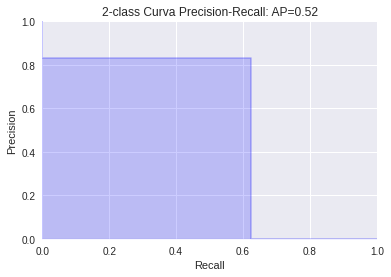

In [171]:
# Plota a recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

The AUROC answers the question: "How well can this classifier be expected to perform in general, at a variety
of different baseline probabilities?" but precision and recall don't. #The ROC curve plots the true positives vs.
 false positives , for a classifier, as its discrimination threshold is varied. Since, a random method describes 
 a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better 
 than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is
  larger), they have better expected performance. 

In [172]:
# Ajustando os pesos do algorítmo
# Ajustes de modelo

# Define o modelo com a sub-amostra balanceada
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5, n_estimators=100)

# Ajusta o modelo de treino com o conjunto de treino
model.fit(X_train, y_train)

# Obtém os valores preditivos e probabilidades do modelo 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Imprime a curva ROC, relatório de classificação e matriz de confusão
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9346828372783376

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12801
           1       0.92      0.75      0.83        16

    accuracy                           1.00     12817
   macro avg       0.96      0.87      0.91     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12800     1]
 [    4    12]]


In [173]:
# Adjusting RF for fraud detection
# Função de modelo sklearn

def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Ajusta o modelo de treino com o conjunto de treino
    model.fit(X_train, y_train)

    # Obtém os valores preditivos e probabilidades do modelo 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Imprime a curva ROC, relatório de classificação e matriz de confusão
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [174]:
# Alterando as opções do modelo
model = RandomForestClassifier(bootstrap=True,
                               class_weight={0:1, 1:12},
                               criterion='entropy',
                               # Muda a profundidade do modelo: 
                               max_depth=10,
                               # Altera o número de amostras nos nós do intervalo 
                               min_samples_leaf=10, 
                               # Altera o número de árvores a utilizar
                               n_estimators=20,
                               n_jobs=-1,
                               random_state=5)

# Executa a função get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9337502929458636

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12801
           1       0.80      0.75      0.77        16

    accuracy                           1.00     12817
   macro avg       0.90      0.87      0.89     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12798     3]
 [    4    12]]


In [175]:
# Parametros de otimização com GridSearchCV

# Define o parametro conjunto para testar
param_grid = {'n_estimators': [1, 30],
              'max_features': ['auto', 'log2'], 
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}

# Define o modelo a usar
model = RandomForestClassifier(random_state=5)

# Combina o conjunto de parâmetros com o modelo definido
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Ajusta o modelo aos dados de treino e obtém os melhores parâmetros
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 30}

In [176]:
# Modelo de resultados com GridSearchCV

# Inserindo os parâmetros de otimização no modelo
model = RandomForestClassifier(class_weight={0:1,1:12},
                               criterion='gini',
                               max_depth=8,
                               max_features='log2', 
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

# Obtendo os resultados do modelo
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9034914264510585

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12801
           1       0.80      0.75      0.77        16

    accuracy                           1.00     12817
   macro avg       0.90      0.87      0.89     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12798     3]
 [    4    12]]


In [177]:
# Métodos de conjuntos

# Regressão logística

# Define o modelo de regressão logística e ajustes
model = LogisticRegression(class_weight={0:1, 1:15}, random_state=5, solver='liblinear')

# Obtém os resultados do modelo
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.8776658073588001

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12801
           1       0.63      0.75      0.69        16

    accuracy                           1.00     12817
   macro avg       0.82      0.87      0.84     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12794     7]
 [    4    12]]


In [178]:
# Classificador de votação

# Define os três classificadores a usar no conjunto
clf1 = LogisticRegression(class_weight={0:1, 1:15},
                          random_state=5,
                          solver='liblinear')

clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, 
                              criterion='gini', 
                              max_depth=8, 
                              max_features='log2',
                              min_samples_leaf=10, 
                              n_estimators=30, 
                              n_jobs=-1,
                              random_state=5)

clf3 = DecisionTreeClassifier(random_state=5,
                              class_weight="balanced")

# Combina os classiificadores com o conjunto modelo
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Obtém os resultados 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12801
           1       0.75      0.75      0.75        16

    accuracy                           1.00     12817
   macro avg       0.87      0.87      0.87     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12797     4]
 [    4    12]]


In [179]:
# Ajustas dos pesos com o Classificador de votação

# Define o conjunto modelo
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Obtém os resultados
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

ROC Score:
0.9082298257948598

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12801
           1       0.75      0.75      0.75        16

    accuracy                           1.00     12817
   macro avg       0.87      0.87      0.87     12817
weighted avg       1.00      1.00      1.00     12817


Confusion Matrix:
[[12797     4]
 [    4    12]]


### **Detecção de fraude usando dados não rotulados**

In [7]:
 # Explorando os dados:

banksim_df = pd.read_csv(banksim_file)
banksim_df.drop(['customer'], axis=1, inplace=True)
# banksim_adj_df = pd.read_csv(banksim_adj_file)
# banksim_adj_df.drop(['step'], axis=1, inplace=True)

In [31]:
#Criando uma amostra de 10% do df original
banksim_df2 = banksim_df.sample(frac=0.01)

In [69]:
banksim_df2.shape

(20, 6)

In [33]:
banksim_df2.head()

,step,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
333795,108,3,F,28007,M348934600,28007,es_transportation,37.62,0
156314,55,2,M,28007,M348934600,28007,es_transportation,35.28,0
357603,115,3,F,28007,M1823072687,28007,es_transportation,31.57,0
465347,145,2,F,28007,M1823072687,28007,es_transportation,13.39,0
212999,72,3,M,28007,M1823072687,28007,es_transportation,31.34,0


In [19]:
banksim_adj_df.shape

(7189, 19)

In [20]:
banksim_adj_df.head()

,Unnamed: 0,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [34]:
banksim_df2.groupby(['category']).mean()

,step,zipcodeOri,zipMerchant,amount,fraud
category,,,,,
es_barsandrestaurants,82.223881,28007.0,28007.0,40.403284,0.029851
es_contents,122.714286,28007.0,28007.0,33.008571,0.000000
es_fashion,102.950820,28007.0,28007.0,72.888689,0.016393
es_food,105.580000,28007.0,28007.0,39.557680,0.000000
es_health,95.260870,28007.0,28007.0,153.835942,0.152174
es_home,91.000000,28007.0,28007.0,136.617000,0.100000
es_hotelservices,120.375000,28007.0,28007.0,178.105625,0.312500
es_hyper,61.229167,28007.0,28007.0,44.065208,0.020833
es_leisure,92.000000,28007.0,28007.0,275.766250,0.875000


In [35]:
banksim_df2.groupby(['age']).mean()

,step,zipcodeOri,zipMerchant,amount,fraud
age,,,,,
0,112.461538,28007.0,28007.0,46.724231,0.038462
1,95.492334,28007.0,28007.0,31.924702,0.003407
2,95.362827,28007.0,28007.0,39.640455,0.017801
3,93.084734,28007.0,28007.0,36.427836,0.016807
4,96.108401,28007.0,28007.0,34.382746,0.009937
5,95.520000,28007.0,28007.0,38.024250,0.018333
6,92.782143,28007.0,28007.0,38.144357,0.010714
U,88.875000,28007.0,28007.0,38.953750,0.000000


In [36]:
banksim_df2.age.value_counts()

2    1910
3    1428
4    1107
5     600
1     587
6     280
0      26
U       8
Name: age, dtype: int64

In [37]:
# Usando estatísticas para definir o comportamento normal

# Criando dois dataframes com dados de fraude e não fraude 
df_fraud = banksim_df2[banksim_df2.fraud == 1] 
df_non_fraud = banksim_df2[banksim_df2.fraud == 0]

In [83]:
df_non_fraud.head()

,amount
0,72
1,-53
2,17
3,92
4,-33


In [80]:
# Normalizando os dados:

np.random.seed(0)

df_fraud = pd.DataFrame(np.random.randint(-100,100,size=(50, 1)), columns=['amount'])

def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

df_mean_norm_fraud = mean_norm(df_fraud)
print(df_mean_norm_fraud)


      amount
0   1.215869
1  -0.870386
2   0.297917
3   1.549670
4  -0.536585
5   1.599740
6   0.064257
7  -1.504607
8  -1.304327
9  -1.053976
10 -0.202784
11 -0.486515
12 -0.186094
13  0.681788
14 -0.686795
15  1.566360
16 -1.003906
17 -0.202784
18  1.249250
19 -0.186094


In [94]:
# Normalizando os dados:

np.random.seed(0)

df_non_fraud = pd.DataFrame(np.random.randint(-100,100,size=(50, 1)), columns=['amount'])

def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

df_mean_norm = mean_norm(df_non_fraud)
print(df_mean_norm)


      amount
0   1.074870
1  -0.989013
2   0.166762
3   1.405092
4  -0.658791
5   1.454625
6  -0.064393
7  -1.616433
8  -1.418300
9  -1.170634
10 -0.328570
11 -0.609258
12 -0.312059
13  0.546516
14 -0.807391
15  1.421603
16 -1.121101
17 -0.328570
18  1.107892
19 -0.312059
20 -0.427637
21  0.959293
22 -1.352256
23 -0.493681
24 -0.576236
25 -1.616433
26  0.678605
27  0.133740
28  1.487647
29 -0.460659
30  1.124403
31  1.405092
32 -0.411125
33 -0.130437
34  1.157426
35 -1.286212
36  0.662094
37  0.662094
38  0.579538
39  0.992315
40 -1.236679
41  1.421603
42 -1.616433
43  1.289514
44  0.331872
45 -1.236679
46 -1.253190
47  0.728138
48  0.926271
49  0.117229


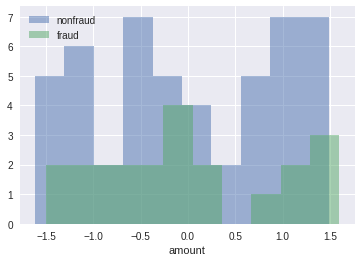

In [95]:
# Plot histogramas das quantidades de dados em fraude and não-fraude 
plt.hist(df_mean_norm.amount, alpha=0.5, label='nonfraud')
plt.hist(df_mean_norm_fraud.amount, alpha=0.5, label='fraud')
plt.xlabel('amount')
plt.legend()
plt.show()


In [43]:
# Métodos de clusterização para detectar fraude

# Importando pacotes
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Transformamando e escalando os dados
X = np.array(df4).astype(np.float)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define o modelo k-means e ajusta aos dados
kmeans = KMeans(n_clusters=6, random_state=42).fit(X_scaled)

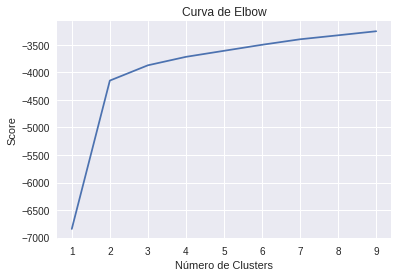

In [44]:
clust = range(1, 10) 
kmeans = [KMeans(n_clusters=i) for i in clust]

score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

plt.plot(clust,score)
plt.xlabel('Número de Clusters')
plt.ylabel('Score')
plt.title('Curva de Elbow')
plt.show()

In [45]:
# Escalando os dados

labels = banksim_adj_df.fraud

In [46]:
cols = ['age', 'amount', 'M', 'es_barsandrestaurants', 'es_contents',
        'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices',
        'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys',
        'es_tech', 'es_transportation', 'es_travel']

In [47]:
# Definindo os valores do df para X como float
X = banksim_adj_df[cols].values.astype(np.float)

In [48]:
X.shape

(7189, 17)

In [57]:
# Define a escala e aplica aos dados
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
# Clusterização K-mean

# Define o modelo
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Ajusta o modelo aos dados escalados
kmeans.fit(X_scaled)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=0, reassignment_ratio=0.01,
                tol=0.0, verbose=0)

In [59]:
# Método Elbow

# Define o intervalo de clusters para tentar
clustno = range(1, 10)

# Executa o MiniBatch Kmeans sobre o número de clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtém o score de cada modelo
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

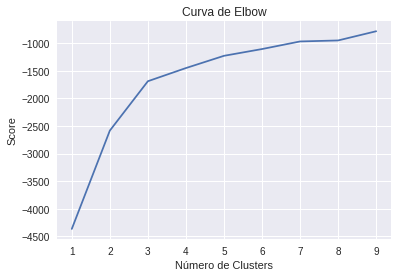

In [60]:
# Plot o modelo e seus respectivos scores
plt.plot(clustno, score)
plt.xlabel('Número de Clusters')
plt.ylabel('Score')
plt.title('Curva de Elbow')
plt.show()

In [61]:
# Atribundo fraude x não-fraude


# Sinalizando Fraude baseada na distância do Centroid

# Executa o modelo kmeans nos dados escalados
kmeans = KMeans(n_clusters=6, random_state=42,n_jobs=-1).fit(X_scaled)

# Obtém o número de cluster de cada datapoint
X_clusters = kmeans.predict(X_scaled)

# Salva o cluster centroids
X_clusters_centers = kmeans.cluster_centers_

# Calcula a distância ao cluster centroid para cada ponto
dist = [np.linalg.norm(x-y) for x,y in zip(X_scaled, X_clusters_centers[X_clusters])]

# Cria previsão baseada na distância
km_y_pred = np.array(dist)
km_y_pred[dist>=np.percentile(dist, 93)] = 1
km_y_pred[dist<np.percentile(dist, 93)] = 0

In [ ]:
# Detectando outliers (anomalias)

# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define modelo K-means
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtém predições e calcula a distância do cluster ao centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Cria predições de fraude baseado em anomalias no cluster
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

In [ ]:
# Verificando resultados do modelo

def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# Obtém o score ROC
roc_auc_score(y_test, km_y_pred)

0.8109115999408585

Confusion matrix, without normalization


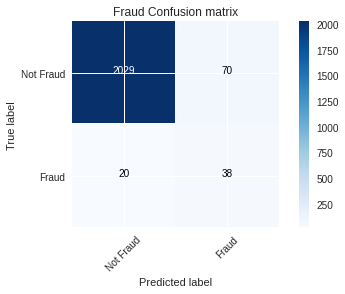

In [ ]:
# Cria a matriz de confusão
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot a matris de confusão para visualizar o resultado 
plot_confusion_matrix(km_cm)

In [ ]:
# Métodos alternativos de clusterização para detecção de fraude

# Implementando o DBSCAN

from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1).fit(X_scaled)

In [ ]:
# Obtendo as etiquetas do cluster (aka numbers)
pred_labels = db.labels_

In [ ]:
# Conta o número total de clusters
n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

In [ ]:
# Imprime os resultados do modelo
print(f'Estimated number of clusters: {n_clusters_}')

Estimated number of clusters: 22


In [ ]:
# Obtém a amostra de contagem em cada cluster 
counts = np.bincount(pred_labels[pred_labels>=0])
print(counts)

[3252  145 2714   55  174  119  122   98   54   13   76   43   25   51
   47   42   15   15   19   23   18   10]


In [ ]:
# DB scan

# Initializando e ajustando p modelo DBscan
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtém as etiquetas preditivas e calcula o número de clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

In [ ]:
# Imprime a métrica de perfornance do DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


In [ ]:
# Acessando os menores clusters

# Conta observações em cada número do cluster
counts = np.bincount(pred_labels[pred_labels >= 0])
print(counts)

[3252  145 2714   55  174  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]


In [ ]:
# Ordena a amostra de contagem de clusters e obtém as 3 menores
smallest_clusters = np.argsort(counts)[:3]

In [ ]:
print(f'The smallest clusters are clusters: {smallest_clusters}')

The smallest clusters are clusters: [21 17  9]


In [ ]:
# Imprime a contagem apenas dos menores clusters
print(f'Their counts are: {counts[smallest_clusters]}')

Their counts are: [10 15 15]


In [ ]:
# Verifica os resultados

# Cria um dataframe com a predição de números de clusters e etiqueta de fraude 
df6 = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Cria uma condição de sinalização de fraude para os menores clusters 
df6['predicted_fraud'] = np.where((df6['clusternr'].isin([21, 17, 9])), 1 , 0)

In [ ]:
# Executa um crosstab nos resultados ( tabulação cruzada )
print(pd.crosstab(df6['fraud'], df6['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              6973  16
1               176  24


### **Fraud detection using text**

In [ ]:
# Contagem de palavras para sinalizar fraude com pandas
# Usando um operador de strings para encontrar palavras
# Busca de palavras em dataframes

In [180]:
df5 = pd.read_csv(enron_emails_clean_file)

In [181]:
mask = df5['clean_content'].str.contains('sell enron stock', na=False)

In [182]:
# Seleciona os dados do df usando mask
df5[mask]

,Message-ID,From,To,Date,content,clean_content
154,<6336501.1075841154311.JavaMail.evans@thyme>,('sarah.palmer@enron.com'),('sarah.palmer@enron.com'),2002-02-01 14:53:35,\nJoint Venture: A 1997 Enron Meeting Belies O...,joint venture enron meeting belies officers cl...


In [183]:
# Usando uma lista de termos

# Cria uma lista de termos para pesquisar
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

# Filtra e-mails limpos na lista searchfor e seleciona do df 
filtered_emails = df5[df5.clean_content.str.contains('|'.join(searchfor), na=False)]
filtered_emails.head()

,Message-ID,From,To,Date,content,clean_content
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...
2,<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...
3,<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...
4,<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...


In [184]:
# Cria uma sinalização

# Cria uma variável de sinalização quando os e-mails combinam com os termos searchfor
df5['flag'] = np.where((df5['clean_content'].str.contains('|'.join(searchfor)) == True), 1, 0)

# Count the values of the flag variable
count = df5['flag'].value_counts()
print(count)

0    1776
1     314
Name: flag, dtype: int64


In [185]:
from nltk import word_tokenize
from nltk.corpus import stopwords 
import string

In [186]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [187]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [188]:
# Removendo stopwords
# Definindo stopwords para excluír
stop = set(stopwords.words('english'))
stop.update(("to", "cc", "subject", "http", "from", "sent", "ect", "u", "fwd", "www", "com", 'html'))

# Definindo pontuações a excluir e  lemmatizer (lema de uma palavra depende de seu significado e contexto. análise morfológica de palavras )
exclude = set(string.punctuation)

In [189]:
# Limpando os dados de texto
# Imporntando o lemmatizer do nltk
lemma = WordNetLemmatizer()

def clean(text, stop):
    text = str(text).rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())      
    return normalized

In [190]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [191]:
# Limpa os e-mails no df e imprime os resutlados
text_clean=[]
for text in df5['clean_content']:
    text_clean.append(clean(text, stop).split()) 

text_clean[0][:10]

['investools',
 'advisory',
 'free',
 'digest',
 'trusted',
 'investment',
 'advice',
 'unsubscribe',
 'free',
 'newsletter']

In [193]:
# Modelagem de tópico sobre fraude

from gensim import corpora
import gensim

In [192]:
# Cria o dicionário e a coleção
# Define o dicionário
dictionary = corpora.Dictionary(text_clean)

# Define a coleção 
corpus = [dictionary.doc2bow(text) for text in text_clean]

In [194]:
print(dictionary)

Dictionary(33980 unique tokens: ['account', 'accurate', 'acquiring', 'acre', 'address']...)


In [195]:
corpus[0][:10]

[(0, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 6),
 (6, 1),
 (7, 2),
 (8, 4),
 (9, 1)]

In [196]:
# Modelo LDA

# Define o modelo LDA
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

# Salva os tópicos e as 5 principais palavras
topics = ldamodel.print_topics(num_words=5)

# Imprime os resultados
for topic in topics:
    print(topic)

(0, '0.012*"bakernet" + 0.007*"mailto" + 0.005*"aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa" + 0.004*"date" + 0.004*"alert"')
(1, '0.031*"image" + 0.009*"se" + 0.008*"ne" + 0.008*"sp" + 0.008*"wscc"')
(2, '0.035*"enron" + 0.008*"company" + 0.005*"message" + 0.005*"development" + 0.004*"employee"')
(3, '0.029*"enron" + 0.013*"hou" + 0.010*"pm" + 0.008*"please" + 0.007*"e"')
(4, '0.043*"td" + 0.031*"net" + 0.029*"money" + 0.028*"tr" + 0.025*"width"')


In [197]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 182 kB/s 
     |████████████████████████████████| 11.3 MB 32.7 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=9b2582fb94bb5adc495b29a58d76ba6bb27895dd98f3cfb44cf228f3ad4936eb
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take int

In [199]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from collections import Iterable

In [200]:
pyLDAvis.enable_notebook()

In [202]:
# Flagging fraud based on topic
# Using your LDA model results for fraud detection

In [205]:
# Encontrado fraude por meio de tópicos

def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df

In [206]:
# Executa a função get_topic_details e verifica os resultados
topic_details_df = get_topic_details(ldamodel, corpus)

In [207]:
topic_details_df.head()

,Dominant_Topic,% Score
0,0.0,0.597592
1,3.0,0.614697
2,2.0,0.994303
3,2.0,0.993469
4,2.0,0.993403


In [208]:
topic_details_df.tail()

,Dominant_Topic,% Score
2085,1.0,0.909563
2086,2.0,0.599991
2087,1.0,0.999324
2088,1.0,0.998140
2089,2.0,0.808979


In [209]:
# Adiciona o texto original aos detalhes do tema em um dataframe
contents = pd.DataFrame({'Original text': text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)

In [210]:
topic_details.sort_values(by=['% Score'], ascending=False).head(10).head()

,Dominant_Topic,% Score,Original text
154,2.0,0.999957,"[joint, venture, enron, meeting, belies, offic..."
135,2.0,0.999953,"[lawyer, agree, order, safeguard, document, ho..."
849,0.0,0.999877,"[original, message, received, thu, aug, cdt, e..."
263,2.0,0.999808,"[original, message, cook, mary, thursday, octo..."
265,2.0,0.999751,"[u, based, enron, corp, expands, pulp, paper, ..."


In [211]:
topic_details.sort_values(by=['% Score'], ascending=False).head(10).tail()

,Dominant_Topic,% Score,Original text
2081,4.0,0.999631,"[unsubscribe, mailing, please, go, money, net,..."
478,2.0,0.999354,"[greeting, jeff, thanks, make, copy, bring, cl..."
175,2.0,0.999331,"[thanks, pretty, sure, m, mcfadden, might, int..."
2087,1.0,0.999324,"[image, image, image, image, image, image, ima..."
280,2.0,0.999229,"[financial, express, wednesday, october, anti,..."


In [212]:
# Cria uma sinalização para o texto altamente associado com o topico 3
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 3.0), 1, 0)

In [213]:
topic_details_1 = topic_details[topic_details.flag == 1]

In [214]:
topic_details_1.sort_values(by=['% Score'], ascending=False).head(10)

,Dominant_Topic,% Score,Original text,flag
1211,3.0,0.999059,"[start, date, hourahead, hour, hourahead, sche...",1
2039,3.0,0.997666,"[w, e, e, k, e, n, e, v, l, b, l, f, r, decemb...",1
870,3.0,0.997177,"[w, e, e, k, e, n, e, v, l, b, l, f, r, march,...",1
1921,3.0,0.996410,"[w, e, e, k, e, n, e, v, l, b, l, f, r, march,...",1
2020,3.0,0.995852,"[jerry, remove, distribution, nng, outage, rep...",1
2054,3.0,0.995696,"[sound, like, deny, commodity, logic, please, ...",1
2009,3.0,0.995503,"[information, organizational, change, bring, c...",1
978,3.0,0.995249,"[forwarded, vince, j, kaminski, hou, pm, john,...",1
346,3.0,0.995104,"[w, e, e, k, e, n, e, v, l, b, l, f, r, novemb...",1
2057,3.0,0.994941,"[reservation, status, changed, detail, reserva...",1


### **Referências:**

https://www.teses.usp.br/teses/disponiveis/45/45134/tde-01022016-204144/publico/Paulo_Oliveira_Mestrado_PPGCC.pdf

https://towardsdatascience.com/understand-and-build-fp-growth-algorithm-in-python-d8b989bab342

https://trenton3983.github.io/files/projects/2019-07-19_fraud_detection_python/2019-07-19_fraud_detection_python.html

people described by a set of attributes as good or bad credit risks.
https://www.openml.org/d/31

creditcard fraud  in September 2013 by european cardholders
https://www.openml.org/d/42175
https://www.openml.org/d/1597

https://minerandodados.com.br/tres-tecnicas-de-amostragem-de-dados-utilizando-python/

https://www.kaggle.com/vmeh23/general-data-analysis-for-banksim-data-set

https://www.kaggle.com/kartik2112/fraud-detection-banksim?select=bs140513_032310.csv